In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm
from design import BaseDesign
from spectrum import BaseSpectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_reflection_design, make_three_line_filter_design
from utils.loss import calculate_RMS_f_spec

import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle

In [ ]:
design = make_edgefilter_design()

def exp(n_size, total_gt):
    np.random.seed()
    init_n = np.random.random(n_size) * 3 + 1
    init_film = FreeFormFilm(init_n, total_gt, substrate='SiO2')

    # design = make_reflection_design(init_film, wls=np.linspace(695, 939, 500))
    adam_optimizer = AdamFreeFormOptimizer(
        init_film, 
        design.target_specs, 
        max_steps=1000, 
        alpha=0.5,
        record=True, 
        show=False, 
        n_min=1.5, 
        n_max=3,
        wl_batch_size=200
    )

    films, losses = adam_optimizer.optimize()
    return films, losses, copy.deepcopy(init_film)

reps = 10
gts = np.linspace(0, 10000, 20)
n_size = 2000

films_rep, losses_rep, best_film_rep = [], [], []
for rep in range(reps):
    films_rep.append([])
    losses_rep.append([])
    best_film_rep.append([])
    for gt in gts:
        films, losses, best_film = exp(n_size, gt)
        films_rep[-1].append(films)
        losses_rep[-1].append(losses)
        best_film_rep[-1].append(best_film)
        


dependence on hyperparams

In [10]:
for rep in range(10):
    print(calculate_RMS_f_spec(
            best_film_rep[rep][-1], 
            make_reflection_design(wls=np.linspace(695, 939, 500)).target_specs
        ))

2.041762008233896e-06
3.7356053555583488e-06
2.734933339376959e-05
9.841682417071318e-07
3.982293151642602e-10
2.5803695160583645e-07
4.763255287805818e-06
4.218950488008099e-08
9.473165624841748e-06
6.132058740349158e-09


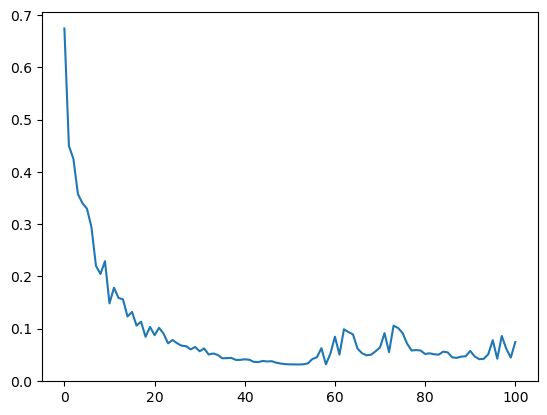

In [27]:
plt.plot(losses_rep[-1][-10])

Text(0, 0.5, 'log10 loss')

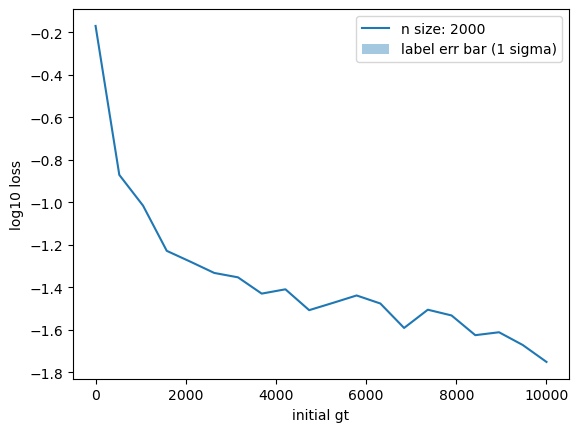

In [29]:
def arr_to_fill(ax, x, arr, rep_axis=0, label=''):
    arr = np.array(arr)
    mean = arr.mean(axis=rep_axis)
    std = arr.std(axis=rep_axis)

    ax.plot(x, mean, label=label,)
    ax.fill_between(x, mean - std, mean + std, label='label'+' err bar (1 sigma)', alpha=0.4)

fig, ax = plt.subplots(1, 1)
best_loss_rep = [[
        np.log10(calculate_RMS_f_spec(
            best_film, 
            design.target_specs, 
        )) for best_film in best_film_ls] 
    for best_film_ls in best_film_rep]

arr_to_fill(ax, gts, best_loss_rep, label=f'n size: {n_size}')
ax.legend()
ax.set_xlabel('initial gt')
ax.set_ylabel('log10 loss')


save & load result

In [3]:
def save(fname, *objs):
    dict = {}
    for i, o in enumerate(objs):
        dict[i] = o
    
    with open(fname, 'wb') as f:
        pickle.dump(dict, f)
    
def load(fname):
    with open(fname, 'rb') as f:
        res = pickle.load(f)
    
    ret_objs = []
    for key in res:
        ret_objs.append(res[key])
    
    return ret_objs

In [4]:
# save('tmp', films_rep, losses_rep)
films_rep, losses_rep = load('tmp')


plot film structure

film has no spec. use 700 nm
film has no spec. use 1000 nm
film has no spec. use 700 nm
film has no spec. use 1000 nm
film has no spec. use 700 nm
film has no spec. use 1000 nm


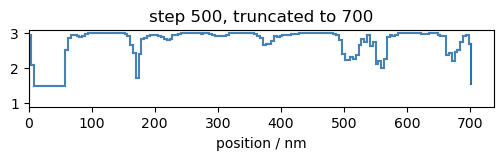

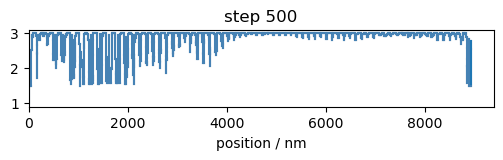

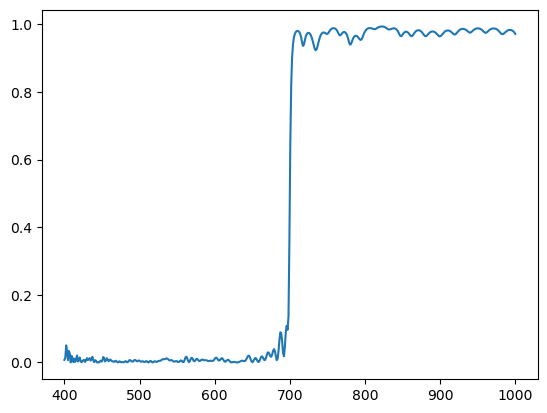

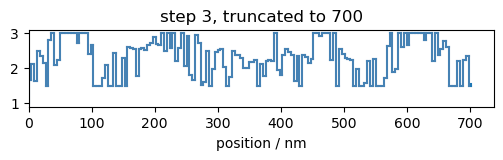

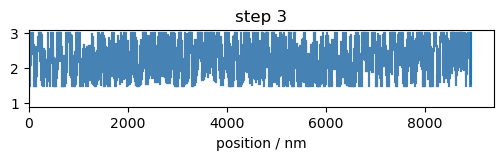

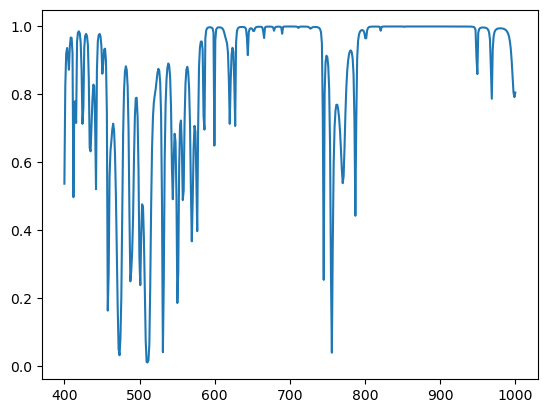

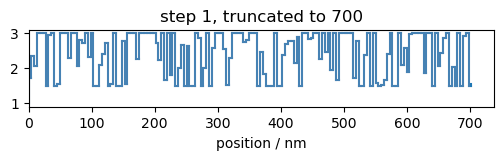

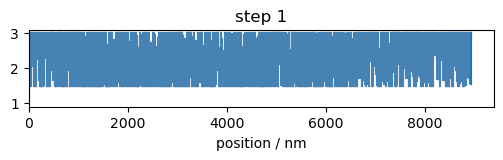

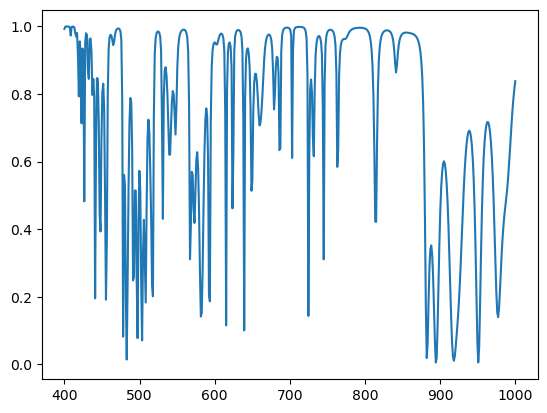

In [24]:
from analyze_utils.structure import plot_layer_thickness

plot_i = [1, 3, -1]
param_id = -3 #  0: min; -1: max
rep_id = 0
truncate_thickness = 700
for i in plot_i[::-1]:
    f: BaseFilm = copy.deepcopy(films_rep[rep_id][param_id][i])
    d = f.get_d()
    sum = 0
    for j, di in enumerate(d):
        if sum > truncate_thickness:
            break
        sum += di
    d = d[:j]

    f.update_d(d)
    wl = 700
    ax, fig = plot_layer_thickness(f, wl)
    ax.set_title(f'step {i if i >= 0 else len(films_rep[rep_id][param_id]) + i}, truncated to {truncate_thickness}')
    # fig.savefig(fpath + f'step_{i}.png', dpi=300, bbox_inches='tight')

    ax, fig = plot_layer_thickness(films_rep[rep_id][param_id][i])
    ax.set_title(f'step {i if i >= 0 else len(films_rep[rep_id][param_id]) + i}')
    # fig.savefig(fpath + f'all_depth_step_{i}.png', dpi=300, bbox_inches='tight')

    # 0-th iter, not yet have spectrum.
    fig, ax = plt.subplots(1, 1)
    ax.plot(films_rep[rep_id][param_id][i].get_all_spec_list()[0].WLS, films_rep[rep_id][param_id][i].get_all_spec_list()[0].get_R())